# stats-to-pandas

#### Import data from Statistics Norway, Sweden, Ireland and the UK to a Pandas dataframe in Python

A tool to make it easier to download data to a pandas dataframe from Statistics Norway (and other agencies) that use json-stat. 

Hans Olav Melberg, 9. June, 2016

## Background

Statistics Norway has made more than 5000 tables available with a new API. In order to download the data, the information the user wants from a table has to be specified as a query in the json-stat format. 

This query is quite verbose and may look complicated. In order to make it easier to write the query, this package provides a graphical user interface that allows the user to select different options. The query is then generated based on the selection. This relies on widgets in the Jupyter notebook. 

The package also provides options for downloading tables without using this interface, by allowing the user to specify the json themselves, manually edit a json string, or just downloading the full table (warning: it may be large). The tool contains various functions to make it easy to specify the json query to get the desired information.

Since several  other statistical agencies also use the stat-json format, the package can be used to download tables from these as well. It works, for instance, with tables from Statistics Sweden. It can also be used to download data based on the full url of a table from other sources, for instance from from the UK ONS and The Central Statistics Office of Ireland.

## Installation

In [ ]:
# (Will work after uploading to pypi, scheduled before 1. july, 2016)
#
# Requires: requests, pyjstat, jupyter, ipywidgets, IPython
#
#pip install stats-to-pandas
#
#import stats-to-pandas as stp

## Overview

####   1. Search for tables based on keywords

In [ ]:
search('cows')

#### 2. Select a table id from the dataframe and create a gui-box to select the variables to be included 

In [ ]:
box = select(table_id = '10714')

#### 3. Read the variable selection from the gui-box and download the data from Statistics Norway

In [ ]:
df = read_box(box)

#### 4. More

In [ ]:
# Read all values for all variables for table with id 10714
# (Avoid having to select variables, step 2 above, but may result in large tables)
df = read_all(table_id = '10714')

# Get the json string for a full query of table number 10714
query = full_json(table_id = '10714', out = 'str')

# Get the json dict for a full query of table number 10714
query = full_json(table_id = '10714', out = 'dict')

# Get the json dict associated with the current selection from a widget box
query = get_json(box)

# Read data from Statistics Ireland
irl_url = 'http://www.cso.ie/StatbankServices/StatbankServices.svc/jsonservice/responseinstance/CNA31' 
df = read_url(full_url = irl_ulr)

## Required modules

In [1]:
# The following has to be installed: 
#    pandas, requests, pyjstat, ipywidgets, jupyter, IPython
#
# The last two (jupyter and ipywidgets) are required to create a gui 
# that makes it easier to build a query. They are not needed to download 
# data if you give the full_url or specify the json query yourself.

import pandas as pd
import requests
import ast
from pyjstat import pyjstat
from collections import OrderedDict
from ipywidgets import widgets
from IPython.display import display

# todo: consider using jsonstat instead of pyjstat

In [2]:
from __future__ import print_function

## Defaults

In [3]:
# This is mainly to make the script flexible for future changes
# Makes it easier to use the same script for sources other than Statistics Norway
# The user can set a different source to be the default
# (note to self: is the extra complexity worth it? 
# more complex since functions now require defaults to be used easily)

Statistics_Norway = {'base_url' : ['http://data.ssb.no/api/v0'], 
                     'language' : ['en', 'no'], 
                     'api_key' : [None]}

# Add more sources here Statistics_Sweden = {...} etc

# set a default
default = Statistics_Norway

# make a list of the different sources
sources = ['Statistics_Norway']

## Search for tables

In [6]:
# to search for tables in statistics norway

def search(phrase, 
           language = 'en', 
           base_url = http://data.ssb.no/api/v0):
    """
        Search for tables that contain the phrase in Statistics Norway.
        Returns a pandas dataframe with the results.
            
        Example
        -------
        
            df = search("income")
        
        
        Parameters
        ----------
        
        phrase: string
            The phrase can contain several words (space separated): 
                search("export Norwegian parrot")
            
            It also supports trucation: 
                search("pharma*")
                
            Not case sensitive.
            Language sensitive (specified in the language option)
            
        language: string 
            default in Statistics Norway: 'en' (Search for English words) 
            optional in Statistics Norway: 'no' (Search for Norwegian words)
                   
        url: string
            default in Statistics Norway: 'http://data.ssb.no/api/v0'
            different defaults can be specified
       
        """
    
    # todo: make converter part of the default specification only for statistics norway
    convert = {'æ' : '%C3%A6', 'Æ' : '%C3%86', 'ø' : '%C3%B8', 'Ø' : '%C3%98', 
             'å' : '%C3%A5', 'Å' : '%C3%85',
             '"' : '%22', '(' : '%28', ')' : '%29', ' ' : '%20'}

    search_str = '{base_url}/{language}/table/?query={phrase}'.format(
        base_url = base_url, 
        language = language, 
        phrase = phrase)
    
    for k, v in convert.items():
        search_str = search_str.replace(k, v)
    
    #print(search_str)    
    
    df = pd.read_json(search_str)
    
    if len(df) == 0:
        print("No match")
        return df
    
    # make the dataframe more readable
    # (is it worth it? increases vulnerability. formats may differ and change)
    # todo: make search and format conditional on the database being searched    
       
    # split the table name into table id and table text
  
    df['table_id'] = df['title'].str.split(':').str.get(0)
    df['table_title'] = df['title'].str.split(':').str.get(1)
    del df['title']
    
    # make table_id the index, visually more intuitive with id as first column
    df = df.set_index('table_id')
    
    # change order of columns to make it more intuitive (table_title is first) 
    cols = df.columns.tolist()
    cols.sort(reverse = True)
    df = df[cols[:-2]]

    return df

#### Search for table with the text cow and put the result in a dataframe called tables

In [7]:
tables = search("cows")
tables.head()

,table_title,score,published
table_id,,,
03789,"Dairy cows per 1 January, by size of herd 199...",1.102974,2016-04-08T10:00:00
03802,"Beef cows per 1 January, by size of herd 1998...",1.047124,2016-04-08T10:00:00
05593,"Cows per 1 January, by size of herd 1998 - 2016",1.047124,2016-04-08T10:00:00
10714,"Holdings housing cows, cattle places for cows...",0.914131,2014-12-17T10:00:00
04426,Number of domestic animals per 31 July 1995 -...,0.515449,2012-11-26T10:00:00


## Get information about variables

In [8]:
def get_variables(
        table_id = None,
        source = None, 
        language = 'en',
        base_url = http://data.ssb.no/api/v0,
        full_url = None):
    """
        Returns a list. 
        
        Each element of the list is a dictionary that provides more 
        information about a variable. 
        
        For instance, one variable may contain information about the
        different years that are available.
        
        
        Parameters
        ----------
    
            table_id: string
                the unique table_id number, a string including leading zeros.
                                
            language: string
                default 'en' (default, English) 
                optional: 'no' (Norwegian)
            
            base_url: string
                base url locating the table (not including table identifier)
            
            full_url: string 
                The full url to the table.
                If full_url is specified, other paramaters are ignored.
                
    """
    
    if full_url is None:
          full_url = '{base_url}/{language}/table/{table_id}'.format(
            base_url = base_url, language = language, table_id = table_id)
    
    df = pd.read_json(full_url)
    variables = [dict(values) for values in df.iloc[:,1]]
    
    return variables

In [39]:
variables = get_variables(table_id = '03789')
print(variables)

[{'values': ['00', '01', '02', '03', '04', '05', '06'], 'elimination': True, 'code': 'BuskapStr', 'text': 'size of herd', 'valueTexts': ['Total', '1-4', '5-9', '10-14', '15-19', '20-29', '30-']}, {'values': ['Driftseiningar', 'Mjolkeku'], 'code': 'ContentsCode', 'text': 'contents', 'valueTexts': ['Holdings keeping dairy cows', 'Dairy cows']}, {'values': ['1998', '1999', '2000', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016'], 'code': 'Tid', 'time': True, 'text': 'year', 'valueTexts': ['1998', '1999', '2000', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016']}]


In [9]:
def select(table_id = None, 
           language = 'en', 
           base_url = http://data.ssb.no/api/v0, 
           full_url = None):
    """
    Selects a table based on the table_id and returns a widget container 
    in which the user can select the set of variables and values to be 
    included in the final table.
    
    
    Example
    --------
    box = select(table_id = '10714')
    
    
    Parameters
    ----------    
    
        table_id : string 
            the id of the desired table
         
        language: string
            language for table
            'en' (default, English) 
            'no' (Norwegian): 
            language for table
        
        base_url: string.
            base url locating the table (not including table_id)
        
        full_url: string
            the full url to the table
    """
        
    # get table_id not full url was specified 
    if full_url is None:
        full_url = '{base_url}/{language}/table/{table_id}'.format(
                    base_url = base_url, 
                    language = language, 
                    table_id = table_id)
        
    table_info = pd.read_json(full_url)
    table_title = table_info.iloc[0,0]

    # get a list with dictionaries containing information about each variable
    variables = get_variables(table_id = table_id, 
                              language = language,
                              base_url = base_url,
                              full_url = full_url)
    
    # get number of variables (ok, childish approach, can be simplified!)
    nvars = len(variables)
    var_list = list(range(nvars))
    
    # a list of dictionaries of the values available for each variable
    option_list = [OrderedDict(zip(variables[var]['valueTexts'], 
                                   variables[var]['values'])) 
                   for var in var_list]
    
    # create a selection widget for each variable
    # todo: skip widget or make it invisible if there is only one option?
    # todo: make first alternative a default selection initially for all tables?
    # todo: add buttons for selecting "all", "latest" , "first" and "none"
                         
    selection_widgets = [widgets.widget_selection.SelectMultiple(
                            options = option_list[var], 
                            height = 400, 
                            width = 500) 
                         for var in var_list]
    
    # put all the widgets in a container
    variables_container = widgets.Tab(selection_widgets)

    # label each container with the variable label 
    for var in var_list:
        title = str(variables[var]['text'])
        variables_container.set_title(var, title)
    
    # build widgets and put in one widget container
    headline = widgets.Label(value = table_title, color = 'blue')
    
    endline = widgets.Label(value = '''Select category and click on elements 
        to be included in the table (CTRL-A selects "all")''')
    
    url_text = widgets.Label(value = full_url)
    
    selection_container = widgets.VBox([headline, 
                                        endline, 
                                        variables_container, 
                                        url_text])
    
    selection_container.layout.border = '3px grey solid'
    # may include a "click here when finished" just to make it more intuitive?
    return selection_container

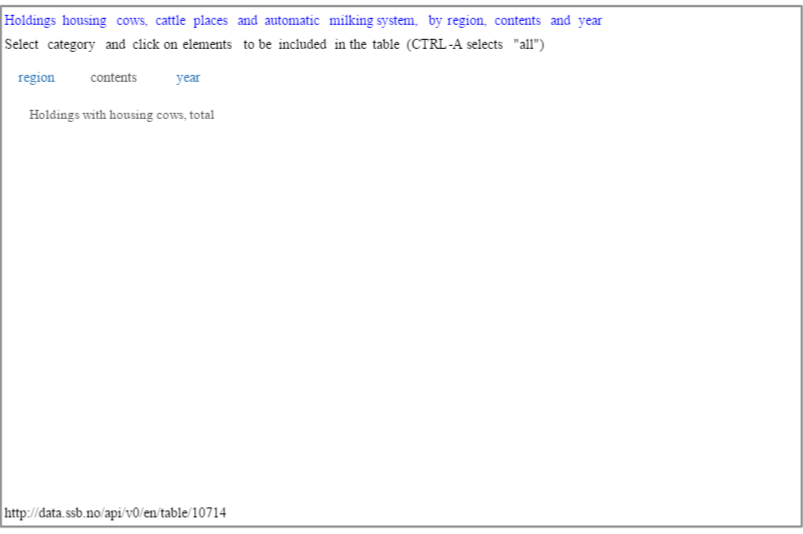

In [10]:
box = select(table_id = '10714')
box

### Sweden

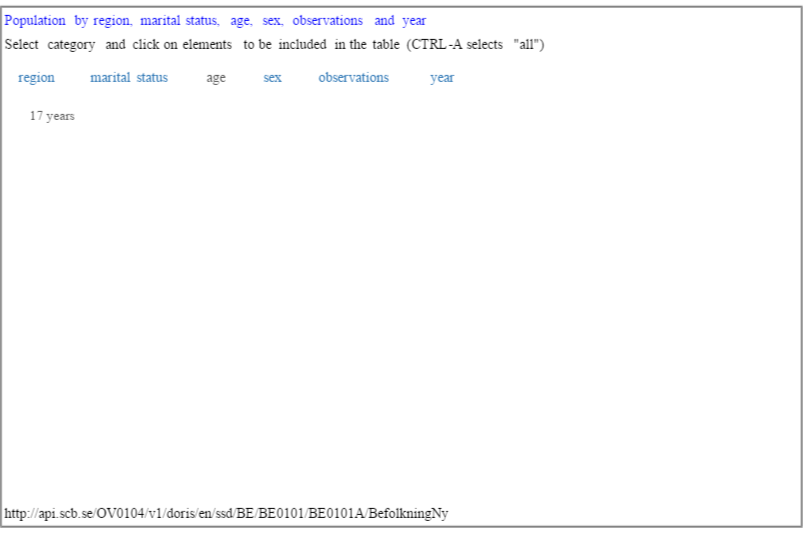

In [11]:
# The box select framework also works for Statistics Sweden 
# The full_url to the table has to be specified since table_id 
# does not have the same structure as in Norway
full_url = 'http://api.scb.se/OV0104/v1/doris/en/ssd/BE/BE0101/BE0101A/BefolkningNy'
box_sweden = select(full_url = full_url)
box_sweden

### Function to get the json query from the widget container

In [12]:
def get_json(box=None, out = 'dict', language = 'en'):
    """
    Takes a widget container as input (where the user has selected varables) 
    and returns a json dictionary or string that will fetch these variables. 
    
    The json follows the json-stat format.
    
    Parameters
    ----------
    
    box : widget container 
        name of widget box with the selected variables
    
    out : string 
        default: 'dict', options: 'str'
        
        The json can be returned as a dictionary or a string.
        The final end query should use a dict, but some may find it useful to
        get the string and revise it before transforming it back to a dict.
    
    
    Example
    -------
    
    json_query = get_json(box)
    
    """
        
    table_url = box.children[3].value
    variables = get_variables(full_url = table_url)
    nvars = len(box.children[2].children)
    var_list = list(range(nvars))
    query_element = {}
    
    # create a dict of strings, one for each variable that specifies 
    # the json-stat that selects the variables/values
    
    for x in var_list:
        value_list = str(list(box.children[2].children[x].value))
        query_element[x] = '{{"code": "{code}", "selection": {{"filter": "item", "values": {values} }}}}'.format(
            code = variables[x]['code'], 
            values = value_list)
        query_element[x] = query_element[x].replace("\'", '"')
    
    all_elements = str(list(query_element.values()))
    all_elements = all_elements.replace("\'", "")

    query = '{{"query": {all_elements} , "response": {{"format": "json-stat" }}}}'.format(all_elements = all_elements)
    
    if out == 'dict':
        query = ast.literal_eval(query)
    
  
    # todo: build it as a dictionary to start with (and not a string that is made into a dict as now)
    # todo: add error message if required variables are not selected
    # todo: avoid repeat downloading of same information 
    # eg. get_variables is sometimes used three times before a table is downloaded
    
    return query

In [13]:
def to_dict(json_str):
    """
        Transforms a string to a dictionary.
        
        Note: Will fail if string is not correctly specified.
    """
    # OK, really unnecessary func, but a concession to less experienced users
    # todo: use json module instead, json.dumps()
    query = ast.literal_eval(json_str)
    return query
    

## Read the data (selected in the box) into a pandas dataframe

Note: A selection has to be made for all the (required) variables in the widget container (box). If not the json-stat specification will be incomplete and read_box() will return an error.

In [14]:
def read_box(from_box):
    """
    Takes a widget container as input (where the user has selected varables) 
    and returns a pandas dataframe with the values for the selected variables.
    
    Example
    -------
    
    df = read_box(box)
    
    """
    query = get_json(from_box)
    url = from_box.children[3].value
    data = requests.post(url, json = query)
    results = pyjstat.from_json_stat(data.json(object_pairs_hook=OrderedDict))
    return results[0]

In [15]:
df = read_box(box)

In [16]:
df.head()

,region,year,value
0,The whole country,1999,27461
1,The whole country,2013,9400


##  Some other useful functions

### Get the json query used to get the data (as specified in the box)

In [17]:
query = get_json(box)
print(query)

{'query': [{'selection': {'values': ['0'], 'filter': 'item'}, 'code': 'Region'}, {'selection': {'values': ['KufjolsIAlt'], 'filter': 'item'}, 'code': 'ContentsCode'}, {'selection': {'values': ['1999', '2013'], 'filter': 'item'}, 'code': 'Tid'}], 'response': {'format': 'json-stat'}}


### Read based on an explicit defined json query, not the box selection

In [18]:
def read_with_json(table_id = None, 
              query = None, 
              language = 'en', 
              base_url = http://data.ssb.no/api/v0, 
              full_url = None):
    """
    Returns a pandas dataframe with the values for the table specified by 
    table_id and an explicit json string (in json-stat format).
    
    Useful if 
        - you know exactly what you are looking for and
        - can specify the json yourself (as a dictionary)
        - you do not want to use the notebook/widgets/box to specify the json query
        
    Hints
    -----
        - use full_json(table_id = '10714', out = 'string') to get a query string and edit it
        - use to_dict(str) to get a dict from an edited json string
            
    Example
    -------
    json_query = {'response': {'format': 'json-stat'}, 
        'query': [
        {'selection': {'values': ['0'], 'filter': 'item'}, 'code': 'Region'}, 
        {'selection': {'values': ['KufjolsIAlt'], 'filter': 'item'}, 'code': 'ContentsCode'}, 
        {'selection': {'values': ['1999', '2013'], 'filter': 'item'}, 'code': 'Tid'}]}
        }
    
    df = read_with_json(table_id = '10714', query = json_query)
    
    """
    if full_url is None:
        
        full_url = '{base_url}/{language}/table/{table_id}'.format(
            base_url = base_url, 
            language = language, 
            table_id = table_id)
        
    data = requests.post(full_url, json = query)
    results = pyjstat.from_json_stat(data.json(object_pairs_hook=OrderedDict))
    return results[0]

In [19]:
json_query = {
    'query': [
        {'selection': {'values': ['0'], 'filter': 'item'}, 'code': 'Region'},
        {'selection': {'values': ['KufjolsIAlt'], 'filter': 'item'}, 'code': 'ContentsCode'},
        {'selection': {'values': ['1999', '2013'], 'filter': 'item'}, 'code': 'Tid'}
            ],
    'response': {'format': 'json-stat'}
            }

df2 = read_with_json(table_id = '10714', query = json_query)

In [20]:
df2.head()

,region,year,value
0,The whole country,1999,27461
1,The whole country,2013,9400


## Reading from other databases (json-stat  format) 
(works when full url to the table is specified)

Many countries and agencies offer json-stat or csv formatted tables that do not need a json specification to be downloaded. Often the sources allow some control of what values (years, geographic units) to be downloaded as part of the url. The following function can be used to download these tables.

In [22]:
def read_url(full_url = None, 
             table_format = 'json'):
    """
    Returns a pandas dataframe of the premade table indicated by the premade 
    table_id or the full_url.
    
    Note: The premade table id may be different from the normal table id.
    """
    
    if full_url is None:
        full_url = '{base_url}/{premade_id}.{table_format}?lang={language}'.format(
                base_url = base_url,
                premade_id = str(premade_id), 
                language = language,
                table_format = table_format)
    #print(full_url)
    
    if table_format == 'json':
        data = requests.get(full_url)
        df = pyjstat.from_json_stat(data.json(object_pairs_hook=OrderedDict))
        df = df[0]
        
    elif table_format == 'csv':
        df = pd.read_csv(full_url)
    else:
        print("""Table_format is incorrectly specified. 
              It must be 'json-stat' or 'csv'""")
        df = None
    return df

### Ireland

In [24]:
irl_url = 'http://www.cso.ie/StatbankServices/StatbankServices.svc/jsonservice/responseinstance/CNA31' 
irl_pop = read_url(irl_url)
irl_pop.head()

,Country of Birth,County,Year,Statistic,value
0,Total Birth,State,1841,Population (Number),6528799
1,Total Birth,State,1851,Population (Number),5111557
2,Total Birth,State,1861,Population (Number),4402111
3,Total Birth,State,1871,Population (Number),4053187
4,Total Birth,State,1881,Population (Number),3870020


###  UK: ONS (Requires api key)

In [25]:
ons_url = 'http://data.ons.gov.uk/ons/api/data/dataset/QS201EW.json?context=Census&apikey=YOUR_API_KEY_HERE&geog=2011WARDH&dm/2011WARDH=E92000001&jsontype=json-stat&totals=false'
df = read_url(ons_url)
df.head()

,2011 Administrative Hierarchy,Ethnic group (Flat) (T019A),Measures,Time Dimension,value
0,England,All categories: Ethnic group,Segment_1,2011,53012456
1,England,Black/African/Caribbean/Black British: Caribbean,Segment_1,2011,42279236
2,England,Asian/Asian British: Bangladeshi,Segment_1,2011,517001
3,England,Asian/Asian British: Chinese,Segment_1,2011,54895
4,England,White: Irish,Segment_1,2011,2430010


### Function to search premade tables in Statistics Norway

Statistics Norway has created premade tables of the most downloaded tables. These tables can be accessed without a json-stat specification. The following functions allow the user to easily search and download these tables. Note that the premade_id is different from the table_id the more general table has in Statistics Norway. Note also that all the premade tables are available using the standard search and read functions, but they then require closer specification of what values the user wants to download.

In [26]:
def search_premade(
    phrase = '*', 
    language = 'en', 
    url = 'http://data.ssb.no/api/v0/dataset'):
    
    """
    Returns a pandas dataframe with the tables matching the tags specified in the search.
    
    Note that the function does not search in the headline of the tables, but in the tags.
    
    The search is exact, so it may be better to get a list of all tables 
    (use phrase = '*' or just leave it unspecified)
    
    The ID column contains a special table id for premade tables 
    (use this is when specifying the table to be downloaded)
    
    Example:
        
        tables = search_url_tables('population')
    
    
    """
    url = '{url}?lang={language}'.format(
        url = url,
        language = language)
    
    df = pd.read_html(url)
    df = df[0]
    df.index = df['ID']
    df = df.iloc[:,[0,1]]
    df = df.sort_index()
    phrase = phrase.lower()
    
    if phrase != '*':
        df = df[(df.iloc[:,0].str.lower().str.contains(phrase)) | 
                (df.iloc[:,1].str.lower().str.contains(phrase)) ]
    return df

# to do: merge the two search functions?
# make premade an bool arg in the search. 
# also allow full_url

In [27]:
search_premade('birth')

,Title,Tags
ID,,
1102,"Population changes. Counties, latest quarter",01222 births deaths emigration folkendrkv immi...
1104,"Population change. Whole country, latest quarter",01222 births deaths emigration folkendrkv immi...
1106,"Population changes. Municipalities, latest 9 q...",01222 births deaths emigration folkendrkv immi...
1108,"Population changes. Municipalities, latest qua...",01222 births deaths emigration folkendrkv immi...
49577,Population 1 January and population changes du...,06913 folkemengde inhabitants municipalities p...
49623,Population 1 January and population changes du...,06913 counties folkendrkv inhabitans births de...
49626,Population 1 January and population changes du...,06913 folkendrkv inhabitants births deaths pop...


### Read premade tables from Statistics Norway

In [28]:
def read_premade(premade_id = None, 
            language = 'en', 
            base_url = 'http://data.ssb.no/api/v0/dataset', 
            full_url = None, 
            table_format = 'json'):
    """
    Returns a pandas dataframe of the premade table indicated by the premade 
    table_id or the full_url.
    
    Note: The premade table id may be different from the normal table id.
    """
    
    if full_url is None:
        full_url = '{base_url}/{premade_id}.{table_format}?lang={language}'.format(
                base_url = base_url,
                premade_id = str(premade_id), 
                language = language,
                table_format = table_format)
    #print(full_url)
    
    if table_format == 'json':
        data = requests.get(full_url)
        df = pyjstat.from_json_stat(data.json(object_pairs_hook=OrderedDict))
        df = df[0]
        
    elif table_format == 'csv':
        df = pd.read_csv(full_url)
    else:
        print("""Table_format is incorrectly specified. 
              It must be 'json-stat' or 'csv'""")
        df = None
    return df

In [29]:
births = read_premade('1052')
births.head()

,sex,age,time,contents,value
0,Both sexes,15-74 years,2015M04,"Unemployment (LFS) (1 000 persons), seasonally...",117
1,Both sexes,15-74 years,2015M04,"Unemployment rate (LFS), seasonally adjusted",4.2
2,Both sexes,15-74 years,2015M05,"Unemployment (LFS) (1 000 persons), seasonally...",118
3,Both sexes,15-74 years,2015M05,"Unemployment rate (LFS), seasonally adjusted",4.3
4,Both sexes,15-74 years,2015M06,"Unemployment (LFS) (1 000 persons), seasonally...",123


## Functions to read everything (no selection)

Avoids the need to specify the json-stat query by automatically generating a query that downloads all variables and valules. Warning: Use with care, the table may be very large.

In [30]:
def full_json(table_id = None, 
              out = 'dict', 
              language = 'en', 
              full_url = None):
    """
    Returns the json query for getting all the values for all options for a table.
    Useful if
        - you do not want to use the widgets/notebook to build the query
        - but want a starting point to revise and specify a the query instead of building it from the ground.
    
    Note
        - The json is a dictionary. You may want to edit the content of the dictionary directly,
        or make it a string, edit it as a string, and retransform it to a dictionary.
        
        To transform a string to a dict, use the function:
        
            query = to_dict(json_str)
        
    Example
    -------
    
    query = full_json(table_id = '10714', out = 'string')
    
    """
    
    variables = get_variables(table_id, language = language, full_url = full_url)
    nvars = len(variables)
    var_list = list(range(nvars))
    
    query_element = {}
    
    for x in var_list:
        query_element[x] ='{{"code": "{code}", "selection": {{"filter": "item", "values": {values} }}}}'.format(
                code = variables[x]['code'], 
                values = variables[x]['values']) 
        query_element[x] = query_element[x].replace("\'", '"')
    all_elements = str(list(query_element.values()))
    all_elements = all_elements.replace("\'", "")
    
    query = '{{"query": {all_elements} , "response": {{"format": "json-stat" }}}}'.format(all_elements = all_elements)
    
    if out == 'dict':
        query = ast.literal_eval(query)
    
    return query


In [31]:
query_str = full_json(table_id = '10714', out = 'str')
query_str

'{"query": [{"code": "Region", "selection": {"filter": "item", "values": ["0", "01", "02-03", "04", "05", "06", "07", "08", "09", "10", "11", "12", "14", "15", "16", "17", "18", "19", "20", "L1-3nyn", "L4", "L5", "L6", "L7"] }}, {"code": "ContentsCode", "selection": {"filter": "item", "values": ["KufjolsIAlt", "Basfjos", "Lausfjos", "KuplassBas", "KuplassLaus", "Mjolkerobotar"] }}, {"code": "Tid", "selection": {"filter": "item", "values": ["1999", "2013"] }}] , "response": {"format": "json-stat" }}'

In [36]:
query_dict = full_json(table_id = '10714', out = 'dict')
cows = read_with_json(table_id = '10714', query = query_dict)
cows.head()

,region,contents,year,value
0,The whole country,"Holdings with housing cows, total",1999,27461
1,The whole country,"Holdings with housing cows, total",2013,9400
2,The whole country,Holdings with cow places in stanchion-tied houses,1999,25872
3,The whole country,Holdings with cow places in stanchion-tied houses,2013,7100
4,The whole country,Holdings with cows places in loose housing,1999,1856


In [37]:
def read_all(table_id = None, 
             language = 'en',
             base_url = http://data.ssb.no/api/v0, 
             full_url = None):
    """
    Returns a pandas dataframe with all values for all options 
    for the table specified by table_id
    
    Warning: The table may be large
    
    Useful if 
        - you know exactly what you are looking for and
        - you do not want to use the notebook/widgets/box to specify the json query)
    
    Example
    
    df = read_all(table_id = '10714')
    
    """
    
     
    if full_url is None:        
        full_url = '{base_url}/{language}/table/{table_id}'.format(
            base_url = base_url,
            language = language, 
            table_id = table_id)
        
    query = full_json(full_url = full_url)
    data = requests.post(full_url, json = query)
    results = pyjstat.from_json_stat(data.json(object_pairs_hook=OrderedDict))
    
    # maybe this need not be its own function, 
    # but an option in read_json? json = 'all'
    
    # other functions(options include: read_recent to get only the 
    # most recent values (defined as x), json = 'recent')
    
    return results[0]

In [38]:
dfall = read_all(table_id = '10714')
dfall.head()

,region,contents,year,value
0,The whole country,"Holdings with housing cows, total",1999,27461
1,The whole country,"Holdings with housing cows, total",2013,9400
2,The whole country,Holdings with cow places in stanchion-tied houses,1999,25872
3,The whole country,Holdings with cow places in stanchion-tied houses,2013,7100
4,The whole country,Holdings with cows places in loose housing,1999,1856


### Suggested future extensions

- Allow multiple tables to be downloaded and automatically merged


### Acknowledgements

This package relies on the work of the authors of pyjstat and json-stat